In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def lmm_drift_tf(L, sigma, dt, corr):
    n_sim, n_mat = tf.shape(L)[0], tf.shape(L)[1]
    drift = []

    for i in range(n_mat):
        if i + 1 == n_mat:
            drift_i = tf.zeros([n_sim])
        else:
            L_j = L[:, i+1:]
            sigma_j = sigma[i+1:]
            rho_ij = corr[i, i+1:]
            numerator = sigma[i] * sigma_j * rho_ij * dt * L_j
            denominator = 1.0 + dt * L_j
            contrib = tf.reduce_sum(numerator / denominator, axis=1)
            drift_i = -contrib
        drift.append(tf.expand_dims(drift_i, axis=1))

    return tf.concat(drift, axis=1)

def lmm_sim_tf_simple(L0, sigma, corr, dt, n_steps, n_sim):
    L0 = tf.convert_to_tensor(L0, dtype=tf.float32)
    sigma = tf.convert_to_tensor(sigma, dtype=tf.float32)
    corr = tf.convert_to_tensor(corr, dtype=tf.float32)

    n_mat = tf.shape(L0)[0]

    # Préparation
    epsilon = 1e-3
    corr += tf.eye(n_mat) * epsilon
    chol = tf.linalg.cholesky(corr)

    all_L = [tf.tile(tf.expand_dims(L0, 0), [n_sim, 1])]  # [n_sim, n_mat]

    for _ in range(n_steps):
        L_prev = all_L[-1]
        drift = lmm_drift_tf(L_prev, sigma, dt, corr)
        Z = tf.random.normal([n_sim, n_mat])
        dW = tf.matmul(Z, tf.transpose(chol)) * tf.sqrt(dt)
        diffusion = dW * sigma
        drift_term = drift - 0.5 * tf.expand_dims(sigma**2, axis=0)
        update = drift_term * dt + diffusion
        L_next = L_prev * tf.exp(update)
        all_L.append(L_next)

    return tf.stack(all_L, axis=1)  # [n_sim, n_steps+1, n_mat]


In [3]:
# --- PINN ---
class PINN(tf.keras.Model):
    def __init__(self, n_maturities):
        super().__init__()
        self.log_sigma = tf.Variable(tf.math.log(0.1) * tf.ones([n_maturities]), trainable=True)
        self.L_raw = tf.Variable(tf.random.normal([n_maturities, n_maturities], stddev=0.1), trainable=True)

    def call(self, inputs=None):
        sigma = tf.exp(self.log_sigma)
        L = tf.linalg.band_part(self.L_raw, -1, 0)
        cov = tf.matmul(L, tf.transpose(L))
        d = tf.sqrt(tf.linalg.diag_part(cov)) + 1e-6
        outer_d = tf.tensordot(d, d, axes=0) + 1e-6
        rho = cov / outer_d
        rho = tf.linalg.set_diag(rho, tf.ones_like(d))
        return sigma, rho


In [4]:
def compute_loss(model, Xtrue, L0, dt):
    sigma, rho = model(tf.zeros((1,)))
    Xsim = lmm_sim_tf_simple(L0, sigma, rho, dt, n_steps=Xtrue.shape[1] - 1, n_sim=Xtrue.shape[0])

    dXtrue = Xtrue[:, 1:, :] - Xtrue[:, :-1, :]
    dXsim = Xsim[:, 1:, :] - Xsim[:, :-1, :]

    loss_diff = tf.reduce_mean(tf.square(dXsim - dXtrue))

    indices = tf.constant([10, 20, 30])
    loss_levels = tf.reduce_mean(tf.square(tf.gather(Xsim, indices, axis=1) - tf.gather(Xtrue, indices, axis=1)))

    # 🎯 Régularisation sur rho : symétrie, diagonale, et norme
    rho_sym = tf.reduce_mean(tf.square(rho - tf.transpose(rho)))
    rho_diag = tf.reduce_mean(tf.square(tf.linalg.diag_part(rho) - 1.0))
    rho_norm = tf.reduce_mean(tf.square(rho))  # empêche les valeurs extrêmes

    loss_rho = rho_sym + rho_diag + 0.01 * rho_norm

    return loss_diff + 0.1 * loss_levels + 0.01 * loss_rho


In [5]:
def compute_loss_one_step(model, Xpast, dXtarget, dt):
    sigma, rho = model(tf.zeros((1,)))
    n_steps = 1
    n_sim = tf.shape(Xpast)[0]
    total_loss = 0.0

    for i in range(n_sim):
        L0 = Xpast[i, -1, :]  # dernier état observé de la séquence
        sim = lmm_sim_tf_simple(L0, sigma, rho, dt, n_steps=1, n_sim=1)
        dXsim = sim[:, 1, :] - sim[:, 0, :]  # shape (1, 40)
        diff = dXsim - dXtarget[i:i+1, -1, :]  # shape (1, 40)
        total_loss += tf.reduce_mean(tf.square(diff))

    return total_loss / tf.cast(n_sim, tf.float32)


In [6]:
    #importation données
    data3000=pd.read_csv("EUR_4Q24_EUR_3000.csv",sep=";", encoding="utf-8")
    data3000 = data3000.replace(',', '.', regex=True).astype(float)
    data3000.columns = data3000.columns.str.replace(' ', '_')
    #On reshape les données en (3000x41x40)
    spot_cols = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
    spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
    spot_data = data3000[spot_cols].values  # shape (123000, 40)
    Xtrain = spot_data.reshape((3000, 41, 40))  # 3000 scénarios, 41 time_steps, 40 maturités

    Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)

In [7]:
# Données d'entraînement
#Xtrain = Xtrain[:3000]  
# Préparer les données pour apprentissage sur 1 pas
Xpast = Xtrain[:, :-1, :]     # shape (n_scenarios, 40, 40)
dX = Xtrain[:, 1:, :] - Xpast # shape (n_scenarios, 40, 40)
L0 = Xtrain[0, 0, :]  # shape (n_mat,)
dt=1.0
batch_size = 128

# Modèle
model = PINN(n_maturities=40)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

for epoch in range(10):
    idx = tf.random.shuffle(tf.range(Xpast.shape[0]))[:batch_size]
    Xbatch = tf.gather(Xpast, idx)
    dXbatch = tf.gather(dX, idx)

    with tf.GradientTape() as tape:
        loss = compute_loss_one_step(model, Xbatch, dXbatch, dt)

    grads = tape.gradient(loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else None for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print(f"Epoch {epoch:03d} - Loss: {loss.numpy():.6f}")


Epoch 000 - Loss: 0.000118
Epoch 001 - Loss: 0.000106
Epoch 002 - Loss: 0.000131
Epoch 003 - Loss: 0.000122
Epoch 004 - Loss: 0.000099
Epoch 005 - Loss: 0.000114
Epoch 006 - Loss: 0.000140
Epoch 007 - Loss: 0.000121
Epoch 008 - Loss: 0.000112
Epoch 009 - Loss: 0.000136


In [8]:
sigma_est, rho_est = model(tf.zeros((1,)))
sigma_np = sigma_est.numpy()
rho_np = rho_est.numpy()
simulated = lmm_sim_tf_simple(
    L0=L0,
    sigma=sigma_np,
    corr=rho_np,
    dt=dt,
    n_steps=Xtrain.shape[1] - 1,
    n_sim=Xtrain.shape[0]
)

In [9]:
print(sigma_est)
print(rho_est)

tf.Tensor(
[0.09952254 0.09953123 0.09952211 0.09955199 0.09950726 0.09953068
 0.09948828 0.09949315 0.09946217 0.09945562 0.09950769 0.09947082
 0.09943381 0.09946305 0.09945039 0.09943585 0.09945916 0.09946992
 0.09942201 0.09942845 0.09941255 0.09941087 0.09944917 0.09939241
 0.09938736 0.09936814 0.09937866 0.09940449 0.09935512 0.0993984
 0.09935848 0.09937473 0.0993707  0.09938695 0.09937267 0.09938587
 0.09934872 0.09935765 0.09934616 0.09936042], shape=(40,), dtype=float32)
tf.Tensor(
[[ 1.          0.9316439   0.52561283 ... -0.16964719  0.3043396
   0.16984738]
 [ 0.9316439   1.          0.6944955  ... -0.17669474  0.24286632
   0.25913078]
 [ 0.52561283  0.6944955   1.         ... -0.07410895  0.08756622
   0.10636435]
 ...
 [-0.16964719 -0.17669474 -0.07410895 ...  1.         -0.08346874
  -0.08412128]
 [ 0.3043396   0.24286632  0.08756622 ... -0.08346874  1.
  -0.18732686]
 [ 0.16984738  0.25913078  0.10636435 ... -0.08412128 -0.18732686
   1.        ]], shape=(40, 40), dt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


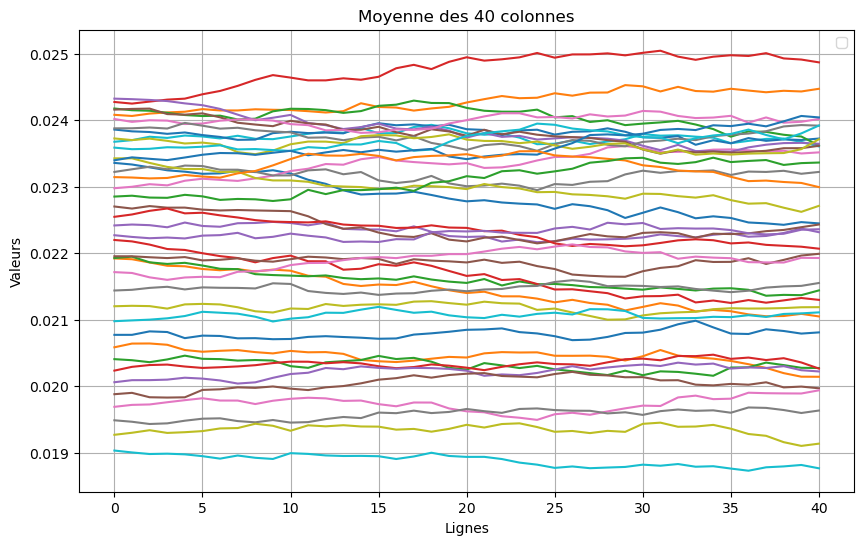

In [10]:
mean_paths = np.mean(simulated, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Sigma constant
sigma = tf.constant([0.3] * 40, dtype=tf.float32)

# Matrice de corrélation : 1 sur la diagonale, 0.5 ailleurs
rho = tf.constant(0.5 * tf.ones((40, 40)), dtype=tf.float32)
rho = tf.linalg.set_diag(rho, tf.ones(40))

# Simulation
scenarios = lmm_sim_tf_simple(L0, sigma, rho, dt, 41, 3000)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


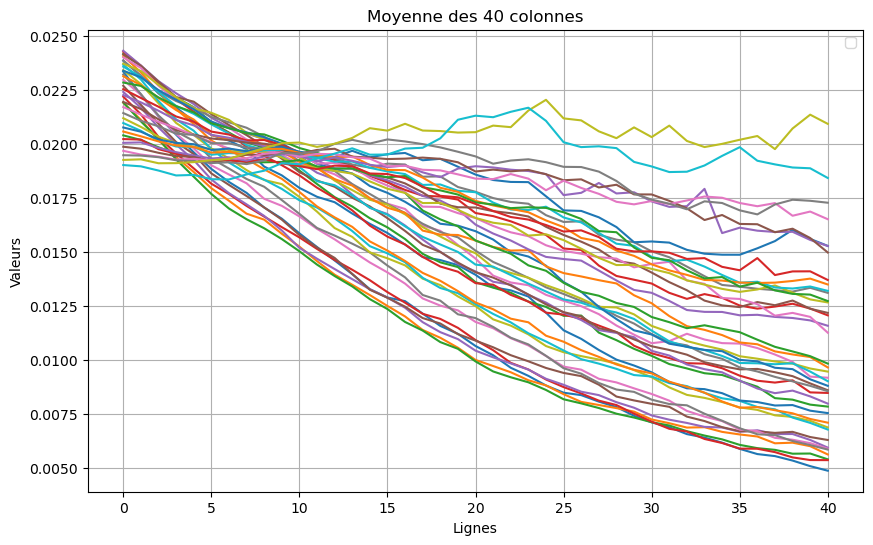

In [12]:
mean_paths = np.mean(scenarios, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
##SANS LE PINN##

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf

# --- Chargement des données ---
data3000 = pd.read_csv("EUR_4Q24_EUR_3000.csv", sep=";", encoding="utf-8")
data3000 = data3000.replace(',', '.', regex=True).astype(float)
data3000.columns = data3000.columns.str.replace(' ', '_')

# Reshape vers (3000, 41, 40)
spot_cols = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
spot_data = data3000[spot_cols].values
Xtrain = spot_data.reshape((3000, 41, 40)).astype(np.float32)

In [15]:
print(Xtrain)

[[[ 2.33600009e-02  2.19244454e-02  2.19296291e-02 ...  1.94906276e-02
    1.92719493e-02  1.90346986e-02]
  [ 4.21266537e-03  4.66137705e-03  5.20220026e-03 ...  1.22679910e-02
    1.21659003e-02  1.20368358e-02]
  [-4.65679262e-03 -4.20458103e-03 -3.78256431e-03 ...  6.98370999e-03
    6.93969242e-03  6.87487936e-03]
  ...
  [ 4.03328128e-02  4.01274413e-02  4.01638970e-02 ...  1.04022153e-01
    1.05474509e-01  1.06840208e-01]
  [ 5.40383905e-02  5.44696786e-02  5.48946969e-02 ...  1.16945378e-01
    1.17947631e-01  1.18875258e-01]
  [ 6.41691908e-02  6.47738799e-02  6.59096614e-02 ...  1.33391112e-01
    1.34506568e-01  1.35539025e-01]]

 [[ 2.33600009e-02  2.19244454e-02  2.19296291e-02 ...  1.94906276e-02
    1.92719493e-02  1.90346986e-02]
  [ 2.26643626e-02  2.34523509e-02  2.40794979e-02 ...  1.93821117e-02
    1.91060472e-02  1.88097581e-02]
  [ 2.85617281e-02  2.92372722e-02  2.95865368e-02 ...  1.81313660e-02
    1.75161585e-02  1.69064160e-02]
  ...
  [ 2.87641212e-02  2.6

In [16]:
def estimate_moments(X, dt=1.0):
    """
    X : ndarray de shape (n_sim, n_steps, n_mat)
        Taux forward (niveaux).
    Renvoie : sigma_emp (40,), rho_emp (40, 40)
    """
    # 1. Calcul des différences absolues
    dX = X[:, 1:, :] - X[:, :-1, :]  # shape = (n_sim, n_steps - 1, n_mat)

    # 2. Estimation de sigma (écart-type annualisé)
    sigma_emp = np.std(dX, axis=(0, 1)) / np.sqrt(dt)

    # 3. Estimation de rho sur les différences
    reshaped = dX.reshape(-1, dX.shape[-1])  # (n_sim * (n_steps-1), n_mat)
    rho_emp = np.corrcoef(reshaped.T)

    return sigma_emp, rho_emp


# --- Modèle de prédiction ---
class SigmaRhoNet(tf.keras.Model):
    def __init__(self, n_mat):
        super().__init__()
        self.n_mat = n_mat
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(41, 40)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(n_mat + n_mat * n_mat)
        ])

    def call(self, x):
        out = self.model(x)
        sigma = tf.nn.softplus(out[:, :self.n_mat])  # shape (batch, 40)

        # On force la sortie à être une matrice de covariance définie positive
        raw = out[:, self.n_mat:]
        tril_elements = tf.reshape(raw, (-1, self.n_mat, self.n_mat))
        L = tf.linalg.band_part(tril_elements, -1, 0)  # on garde partie inférieure
        cov = tf.matmul(L, tf.transpose(L, perm=[0, 2, 1]))  # cov = L @ L.T

        # normalisation en matrice de corrélation
        d = tf.sqrt(tf.linalg.diag_part(cov)) + 1e-6
        outer_d = tf.einsum("bi,bj->bij", d, d)
        rho = cov / outer_d
        rho = tf.linalg.set_diag(rho, tf.ones_like(d))

        return sigma, rho


In [17]:
Xtrain=Xtrain*100
sigma_emp, rho_emp = estimate_moments(Xtrain)


# --- Données TensorFlow ---
X_train = tf.convert_to_tensor(Xtrain[:1], dtype=tf.float32)  # 1er scénario
y_sigma = tf.convert_to_tensor(sigma_emp[None, :], dtype=tf.float32)
y_rho = tf.convert_to_tensor(rho_emp[None, :, :], dtype=tf.float32)

In [18]:
print(sigma_emp)

[0.8641301  0.8709469  0.872248   0.8690034  0.8635828  0.8563937
 0.8482917  0.8399733  0.8317371  0.82359165 0.8155269  0.8074709
 0.79937905 0.7911488  0.7828244  0.77445257 0.7660696  0.7577476
 0.74952126 0.74147046 0.7336187  0.7259932  0.71862257 0.7115105
 0.7046817  0.6981294  0.69188535 0.6858953  0.6801772  0.67468977
 0.66939354 0.6642514  0.65922403 0.6542911  0.64944744 0.6446945
 0.64004487 0.63551563 0.6311268  0.62689185]


In [19]:
print(rho_emp)

[[1.         0.99594554 0.99371225 ... 0.68223107 0.67582538 0.66987642]
 [0.99594554 1.         0.99872582 ... 0.68883748 0.6822592  0.67614238]
 [0.99371225 0.99872582 1.         ... 0.69433228 0.68762134 0.6813747 ]
 ...
 [0.68223107 0.68883748 0.69433228 ... 1.         0.99966486 0.99867884]
 [0.67582538 0.6822592  0.68762134 ... 0.99966486 1.         0.99967287]
 [0.66987642 0.67614238 0.6813747  ... 0.99867884 0.99967287 1.        ]]


In [20]:
# --- Initialisation et entraînement ---
model = SigmaRhoNet(n_mat=40)
optimizer = tf.keras.optimizers.legacy.Adam(1e-3)

def loss_fn(y_sigma_true, y_rho_true, y_sigma_pred, y_rho_pred):
    loss_sigma = tf.reduce_mean((y_sigma_true - y_sigma_pred)**2)
    loss_rho = tf.reduce_mean((y_rho_true - y_rho_pred)**2)
    return loss_sigma + loss_rho

In [21]:
# Entraînement simple
for epoch in range(100):
    with tf.GradientTape() as tape:
        sigma_pred, rho_pred = model(X_train)
        loss = loss_fn(y_sigma, y_rho, sigma_pred, rho_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    print(f"Epoch {epoch:03d} - Loss: {loss.numpy():.6f}")

Epoch 000 - Loss: 1.865828
Epoch 001 - Loss: 0.906654
Epoch 002 - Loss: 0.917161
Epoch 003 - Loss: 0.871960
Epoch 004 - Loss: 0.784250
Epoch 005 - Loss: 0.682962
Epoch 006 - Loss: 0.584335
Epoch 007 - Loss: 0.490648
Epoch 008 - Loss: 0.430730
Epoch 009 - Loss: 0.377146
Epoch 010 - Loss: 0.335982
Epoch 011 - Loss: 0.303354
Epoch 012 - Loss: 0.272679
Epoch 013 - Loss: 0.243333
Epoch 014 - Loss: 0.217474
Epoch 015 - Loss: 0.196080
Epoch 016 - Loss: 0.145828
Epoch 017 - Loss: 0.129625
Epoch 018 - Loss: 0.115395
Epoch 019 - Loss: 0.104883
Epoch 020 - Loss: 0.097339
Epoch 021 - Loss: 0.090865
Epoch 022 - Loss: 0.084561
Epoch 023 - Loss: 0.077977
Epoch 024 - Loss: 0.070604
Epoch 025 - Loss: 0.063247
Epoch 026 - Loss: 0.057383
Epoch 027 - Loss: 0.053272
Epoch 028 - Loss: 0.050459
Epoch 029 - Loss: 0.048660
Epoch 030 - Loss: 0.046716
Epoch 031 - Loss: 0.043403
Epoch 032 - Loss: 0.039376
Epoch 033 - Loss: 0.035784
Epoch 034 - Loss: 0.033273
Epoch 035 - Loss: 0.031796
Epoch 036 - Loss: 0.030644
E

In [22]:
# --- Prédiction finale ---
sigma_final, rho_final = model(X_train)
print("Sigma estimé :", sigma_final.numpy().flatten())
print("Rho estimé :")
print(rho_final.numpy()[0])


Sigma estimé : [0.8636545  0.87465537 0.87047756 0.86283815 0.85707086 0.8555519
 0.8467332  0.8321284  0.8320601  0.8250459  0.8154015  0.8066714
 0.80074877 0.78821063 0.78470534 0.77831995 0.7635551  0.7585019
 0.75109446 0.7384384  0.73544264 0.7230104  0.71980894 0.7129446
 0.70562285 0.7009231  0.69570917 0.68521523 0.679941   0.6749395
 0.677603   0.6661956  0.6550735  0.65913486 0.6519824  0.64698035
 0.6325244  0.6433903  0.63486785 0.62396544]
Rho estimé :
[[1.         0.88975066 0.84038806 ... 0.53802955 0.5220065  0.5317354 ]
 [0.88975066 1.         0.930936   ... 0.59800875 0.6180444  0.58192205]
 [0.84038806 0.930936   1.         ... 0.66839474 0.660906   0.6678947 ]
 ...
 [0.53802955 0.59800875 0.66839474 ... 1.         0.9625602  0.97150135]
 [0.5220065  0.6180444  0.660906   ... 0.9625602  1.         0.9700651 ]
 [0.5317354  0.58192205 0.6678947  ... 0.97150135 0.9700651  1.        ]]


In [23]:
L0 = Xtrain[0, 0, :]/100  # shape (n_mat,)
dt=1.0
simulated = lmm_sim_tf_simple(
    L0=L0,
    sigma=sigma_final[0],
    corr=rho_final[0],
    dt=dt,
    n_steps=41,
    n_sim=3000
)


In [24]:
print(L0)


[0.02336    0.02192445 0.02192963 0.02220091 0.02242037 0.02270455
 0.02297993 0.02322492 0.02342808 0.02367807 0.02386253 0.02408364
 0.02417892 0.02427593 0.02432667 0.02416083 0.02402045 0.0238807
 0.02372887 0.02358985 0.02340005 0.02314636 0.02285444 0.02255015
 0.02227247 0.02195577 0.02171853 0.02144129 0.02120401 0.02097975
 0.02077464 0.0205872  0.02041008 0.02023706 0.02006285 0.0198829
 0.01969329 0.01949063 0.01927195 0.0190347 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


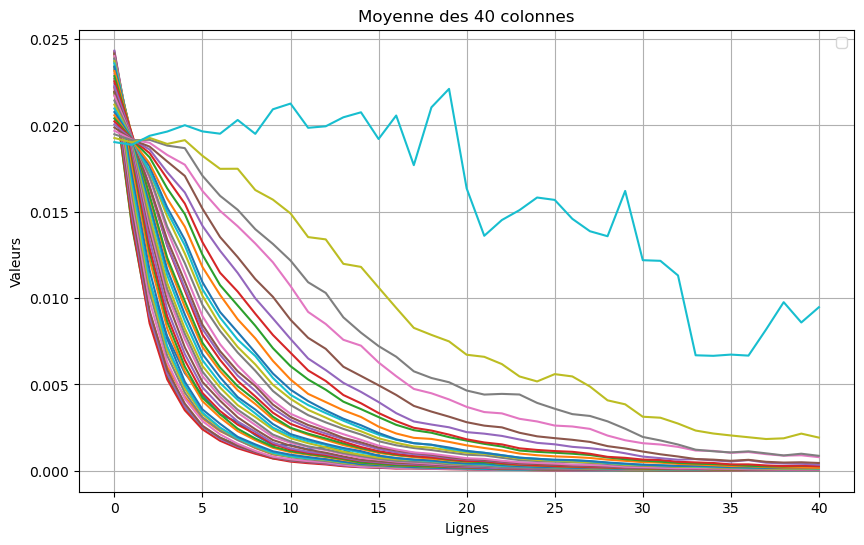

In [25]:
mean_paths = np.mean(simulated, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()
